In [1]:
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from scipy.spatial import ConvexHull

In [2]:
df = pd.read_csv('results/account_value_a2c.csv', names=['index','account_value'])
df = df[df.index >= 1]
account_value = df.account_value
n = len(account_value)

df = pd.read_csv('dataset.csv')
tics = pd.unique(df.tic)

trade_day = 365

prices = pd.DataFrame({})
prices_change = pd.DataFrame({})
variance = pd.Series({},dtype='float64')

for tic in tics:
    prices[tic] = df[df.tic == tic].adjcp[-n:].to_list()
    prices_change[tic] = prices[tic].pct_change().apply(lambda x: np.log(1+x))
    variance[tic] = prices_change[tic].var()
prices['Datetime'] = df[df.tic == tic].datadate[-n:].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')).to_list()
prices = prices.set_index('Datetime')

cov_matrix = prices_change.cov()

expect_return = prices.resample('Y').last().pct_change().mean()
assets = pd.concat([expect_return, variance], axis=1)
assets.columns = ['Returns', 'Variance']
num_assets = len(prices.columns)

assets

Returns  Variance
Bitcoin   1.736725  0.001692
Ethereum  4.405935  0.002574
Monero    1.949778  0.002471

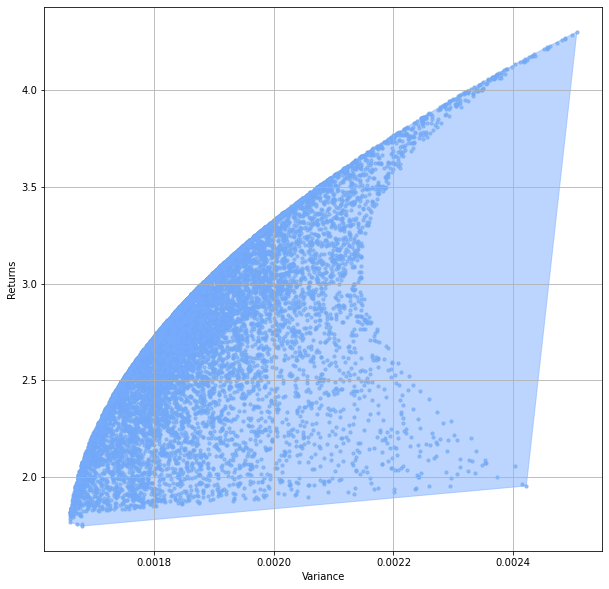

In [3]:

p_ret = []
p_var = []
p_weights = []

num_sample = 10000

for i in range(num_sample):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, expect_return)
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum() # Portfolio Variance
    p_var.append(var)

data = {'Returns':p_ret, 'Variance':p_var}
for counter, symbol in enumerate(prices.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

portfolios_sample  = pd.DataFrame(data)
ax = portfolios_sample.plot.scatter(x='Variance', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

samples = np.vstack((portfolios_sample['Variance'].to_numpy(),portfolios_sample['Returns'].to_numpy())).T
hull = ConvexHull(samples)
plt.fill(samples[hull.vertices,0], samples[hull.vertices,1],color="#78acff",alpha=0.5)
plt.scatter(portfolios_sample['Variance'], portfolios_sample['Returns'],marker='o',color="#78acff",s=10, alpha=0.3)


In [4]:

def get_return(weights):
    return np.dot(weights, expect_return)

def get_variance(weights):
    return cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()

def get_variance_diff(weights):
    diff = np.zeros(len(weights))
    for index in range(len(weights)):
        for tic_i, tic in enumerate(tics):
            diff[index] += 2 * cov_matrix[tic][tics[index]] * weights[tic_i]
    return diff

Returns = []
Variances = []

learn_rate = 0.1

weights = np.zeros(num_assets) + 1/num_assets

min_weight = np.copy(weights)
min_variance = get_variance(weights)

for i in range(400000):

    diff = get_variance_diff(weights)
    weights -= diff * learn_rate
    weights = np.clip(weights, 0, 1)
    weights = weights / sum(weights)
    variance = get_variance(weights)
    returns = get_return(weights)

    if variance > min_variance:
        if learn_rate < 1e-20:
            break
        learn_rate *= 0.99
        weights = np.copy(min_weight)
    else:
        min_variance = variance
        min_weight = np.copy(weights)
        Returns.append(returns)
        Variances.append(variance)

    # print(f'\r{i} weights:{weights} New variance: {variance} learn_rate: {learn_rate}',end="")
    print(f'{i} weights:{weights} New variance: {variance} learn_rate: {learn_rate}',end="\n")


print("\ndone\n\n")
print("weight: ",min_weight)
print("variance: ",min_variance)

data = {'Returns':Returns, 'Variance':Variances}
portfolios  = pd.DataFrame(data)




0 weights:[0.33337849 0.33330073 0.33332078] New variance: 0.0018502205870941642 learn_rate: 0.1
1 weights:[0.3334237  0.33326809 0.33330821] New variance: 0.0018501879933204117 learn_rate: 0.1
2 weights:[0.33346895 0.33323542 0.33329563] New variance: 0.0018501553687822834 learn_rate: 0.1
3 weights:[0.33351425 0.33320271 0.33328304] New variance: 0.0018501227134544202 learn_rate: 0.1
4 weights:[0.33355959 0.33316997 0.33327043] New variance: 0.001850090027311453 learn_rate: 0.1
5 weights:[0.33360499 0.3331372  0.33325782] New variance: 0.0018500573103279985 learn_rate: 0.1
6 weights:[0.33365042 0.33310439 0.33324518] New variance: 0.0018500245624786622 learn_rate: 0.1
7 weights:[0.33369591 0.33307155 0.33323254] New variance: 0.0018499917837380359 learn_rate: 0.1
8 weights:[0.33374144 0.33303868 0.33321988] New variance: 0.0018499589740806986 learn_rate: 0.1
9 weights:[0.33378702 0.33300577 0.33320721] New variance: 0.0018499261334812174 learn_rate: 0.1
10 weights:[0.33383265 0.332972

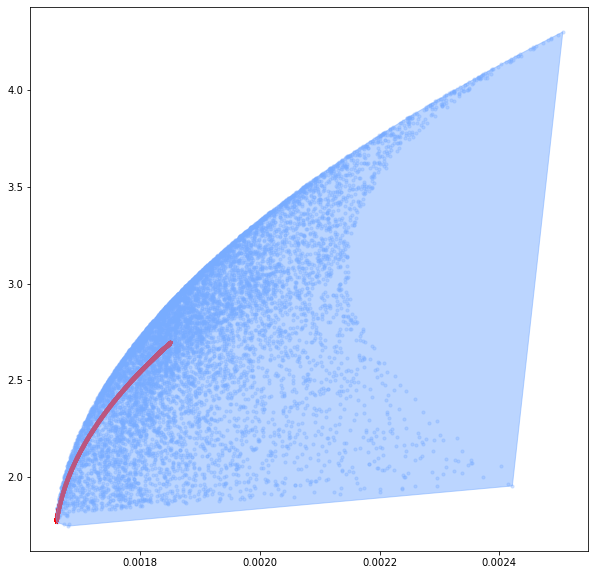

In [5]:
plt.subplots(figsize=[10,10])

samples = np.vstack((portfolios_sample['Variance'].to_numpy(),portfolios_sample['Returns'].to_numpy())).T
hull = ConvexHull(samples)
plt.fill(samples[hull.vertices,0], samples[hull.vertices,1],color="#78acff",alpha=0.5)
plt.scatter(portfolios_sample['Variance'], portfolios_sample['Returns'],marker='o',color="#78acff",s=10, alpha=0.3)
plt.scatter(portfolios['Variance'], portfolios['Returns'], color='r', marker='*', s=10)
plt.show()

Minimum Variance Weight:

Bitcoin :	 0.8306849492697236
Ethereum :	 0.0
Monero :	 0.1693150507302763


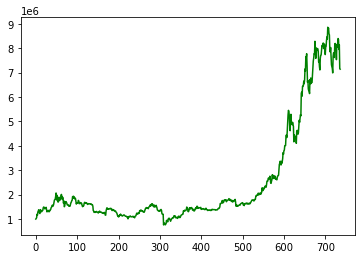

In [6]:
# number of trade date
n = 737

df = pd.read_csv('dataset.csv')
tics = pd.unique(df.tic)

print("Minimum Variance Weight:\n")
weights = {}
for idx, tic in enumerate(tics):
    print(tic,":\t", min_weight[idx])
    weights[tic] = min_weight[idx]

account_value = np.zeros(n)
for tic in tics:
    price = df[df.tic == tic].open[-n:].to_numpy()
    price *= (1000000 * weights[tic]) / price[0]
    account_value += price

pd.DataFrame(account_value).to_csv("./results/account_value_min_var.csv")

plt.plot( account_value, 'g')
plt.show()
